# Similarity search for motif mining

In this tutorial, we demonstrate how to utilize the similarity functionality to discover images with similar motifs from a collection of Reddit images. We employ the classic `SIFT` feature to identify images with a strikingly similar appearance (image-level pipeline).

Additionally, we extend the pipeline by incorporating an object detection model, `YOLO`, in combination with the SIFT feature. This enables us to identify objects within the images that exhibit a similar appearance (object-level similarity).

To illustrate the seamless integration of different vector stores, we leverage the power of multiple vector stores, namely `FAISS` and `QDRANT`, within evadb. This demonstrates the ease with which you can utilize diverse vector stores to construct indexes, enhancing your similarity search experience.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/11-similarity-search-for-motif-mining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB


In [1]:
%pip install --quiet "evadb[vision,document,notebook]"
%pip install --quiet kornia
import evadb
cursor = evadb.connect().cursor()


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Download reddit dataset

In [2]:

!wget -nc https://www.dropbox.com/scl/fo/fcj6ojmii0gw92zg3jb2s/h\?dl\=1\&rlkey\=j3kj1ox4yn5fhonw06v0pn7r9 -O reddit-images.zip
!unzip -o reddit-images.zip -d reddit-images

--2023-06-08 00:31:01--  https://www.dropbox.com/scl/fo/fcj6ojmii0gw92zg3jb2s/h?dl=1&rlkey=j3kj1ox4yn5fhonw06v0pn7r9
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: https://uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com/zip_download_get/Bg_n1TIe-Rpj8XQrqPf2tWuG5IPRQFoTZox_tvDaJGIY0xql83b2V5WvE2lD_TX-Oe-oeAQxGuanYugiLTTWKR4ph5tXDnqxjzRDBXIVIb0bbw# [following]
--2023-06-08 00:31:03--  https://uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com/zip_download_get/Bg_n1TIe-Rpj8XQrqPf2tWuG5IPRQFoTZox_tvDaJGIY0xql83b2V5WvE2lD_TX-Oe-oeAQxGuanYugiLTTWKR4ph5tXDnqxjzRDBXIVIb0bbw
Resolving uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com (uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com)... 

162.125.9.15, 2620:100:601f:15::a27d:90f
Connecting to uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com (uc912506ea27523ad54fa19d99cb.dl.dropboxusercontent.com)|162.125.9.15|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 4397651 (4.2M) [application/zip]
Saving to: ‘reddit-images.zip’


reddit-images.zip     0%[                    ]       0  --.-KB/s               


reddit-images.zip   100%[===================>]   4.19M  23.5MB/s    in 0.2s    

2023-06-08 00:31:03 (23.5 MB/s) - ‘reddit-images.zip’ saved [4397651/4397651]



Archive:  reddit-images.zip
mapname:  conversion of  failed
 extracting: reddit-images/g348_d7jgzgf.jpg  
 extracting: reddit-images/g348_d7jphyc.jpg  
 extracting: reddit-images/g348_d7ju7dq.jpg  
 extracting: reddit-images/g348_d7jhhs3.jpg  
 extracting: reddit-images/g1074_d4n1lmn.jpg  
 extracting: reddit-images/g1074_d4mxztt.jpg  
 extracting: reddit-images/g1074_d4n60oy.jpg  
 extracting: reddit-images/g1074_d4n6fgs.jpg  
 extracting: reddit-images/g1190_cln9xzr.jpg  
 extracting: reddit-images/g1190_cln97xm.jpg  
 extracting: reddit-images/g1190_clna260.jpg  
 extracting: reddit-images/g1190_clna2x2.jpg  
 extracting: reddit-images/g1190_clna91w.jpg  
 extracting: reddit-images/g1190_clnad42.jpg  
 extracting: reddit-images/g1190_clnajd7.jpg  
 extracting: reddit-images/g1190_clnapoy.jpg  
 extracting: reddit-images/g1190_clnarjl.jpg  
 extracting: reddit-images/g1190_clnavnu.jpg  
 extracting: reddit-images/g1190_clnbalu.jpg  
 extracting: reddit-images/g1190_clnbf07.jpg  
 ext

### Load all images into evadb

In [3]:
response = cursor.query("DROP TABLE IF EXISTS reddit_dataset;").df()
cursor.query(
    "LOAD IMAGE 'reddit-images/*.jpg' INTO reddit_dataset;"
).df()


06-08-2023 09:50:33 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_table:0050] Table: reddit_dataset does not exist


,0
0,Number of loaded IMAGE: 34


### Register a SIFT FeatureExtractor 
It uses `kornia` library to extract sift features for each image

In [5]:
cursor.query("DROP UDF IF EXISTS SiftFeatureExtractor;").df()
cursor.query("""CREATE UDF IF NOT EXISTS SiftFeatureExtractor
                    IMPL  '../evadb/udfs/sift_feature_extractor.py'""").df()

06-08-2023 09:50:36 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_udf:0082] UDF SiftFeatureExtractor does not exist, therefore cannot be dropped.


,0
0,UDF SiftFeatureExtractor successfully added to...


In [6]:
# Keep track of which image gets the most votes
from collections import Counter
vote = Counter()

## Image-level similarity search pipeline. 
This pipeline creates one vector per image. Next, we should breakdown steps how we build the index and search similar vectors using the index.

In [7]:
#1. Create index for the entire image
cursor.query("""DROP INDEX IF EXISTS reddit_sift_image_index""").df()
cursor.query("""CREATE INDEX reddit_sift_image_index 
                    ON reddit_dataset (SiftFeatureExtractor(data)) 
                    USING FAISS""").df()

06-08-2023 09:50:37 WARNING[drop_object_executor:drop_object_executor.py:_handle_drop_index:0107] Index reddit_sift_image_index does not exist, therefore cannot be dropped.


,0
0,Index reddit_sift_image_index successfully add...


In [8]:
#2. Search similar vectors
response = cursor.query("""SELECT name FROM reddit_dataset ORDER BY
                    Similarity(
                      SiftFeatureExtractor(Open('reddit-images/g1190_clna260.jpg')),
                      SiftFeatureExtractor(data)
                    )
                    LIMIT 5""").df()

In [9]:
#3. Update votes
for i in range(len(response)):
    vote[response["reddit_dataset.name"][i]] += 1
print(vote)

Counter({'reddit-images/g1190_clna260.jpg': 1, 'reddit-images/g1190_clndsnu.jpg': 1, 'reddit-images/g1190_clna91w.jpg': 1, 'reddit-images/g1190_clnc4uy.jpg': 1, 'reddit-images/g1190_cln97xm.jpg': 1})


## Object-level similarity search pipeline. 
This pipeline detects objects within images and generates vectors exclusively from the cropped objects. The index is then constructed using these vectors. To showcase the versatility of `evadb`, we leverage `Qdrant` vector store specifically for building this index. This demonstrates how seamlessly you can leverage different vector stores within evadb.

### 1. Extract all the object using `Yolo` from the images

In [10]:
create_index_query = """
    CREATE MATERIALIZED VIEW IF NOT EXISTS 
      reddit_object_table (name, data, bboxes,labels)
      AS SELECT name, data, bboxes, labels FROM reddit_dataset
      JOIN LATERAL UNNEST(Yolo(data)) AS Obj(labels, bboxes, scores)"""
cursor.query(create_index_query).df()

2023-06-08 09:50:42,010	INFO worker.py:1625 -- Started a local Ray instance.


""


### 2. Build an index on the feature vectors of the extracted objects

In [11]:
cursor.query("""CREATE INDEX reddit_sift_object_index
                    ON reddit_object_table (SiftFeatureExtractor(Crop(data, bboxes)))
                    USING QDRANT""").df()

,0
0,Index reddit_sift_object_index successfully ad...


In [12]:
# Create a cropped images (We are actively working on features to allow
# us to not do this outside SQL)
response = (
    cursor.query(
        "LOAD IMAGE 'reddit-images/g1190_clna260.jpg' INTO reddit_search_image_dataset"
    )
    .df()
)
print(response)
response = (
    cursor.query("SELECT Yolo(data).bboxes FROM reddit_search_image_dataset;")
    .df()
)
print(response)


import cv2
import pathlib

bboxes = response["yolo.bboxes"][0]

img = cv2.imread("reddit-images/g1190_clna260.jpg")
pathlib.Path("reddit-images/search-object/").mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(bboxes):
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    cropped_img = img[ymin:ymax, xmin:xmax]
    cv2.imwrite(f"reddit-images/search-object/search-{i}.jpg", cropped_img)


                           0
0  Number of loaded IMAGE: 1


                                         yolo.bboxes
0  [[257.2467956542969, 256.8749084472656, 457.67...


### 3. Retrieve using object-level similarity search

In [13]:
#4. 
import os

for path in os.listdir("reddit-images/search-object/"):
    path = "reddit-images/search-object/" + path
    query = f"""SELECT name FROM reddit_object_table ORDER BY
                        Similarity(
                          SiftFeatureExtractor(Open('{path}')),
                          SiftFeatureExtractor(data)
                        )
                        LIMIT 1"""
    response = cursor.query(query).df()
    for i in range(len(response)):
        vote[response["reddit_object_table.name"][i]] += 0.5

    print(response)

06-08-2023 09:51:08 WARNING[batch:batch.py:merge_column_wise:0266] Duplicated column name detected                          siftfeatureextractor.features  \
0    [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
1    [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
2    [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
3    [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
4    [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
..                                                 ...   
102  [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
103  [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
104  [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
105  [[0.08674885, 0.085803166, 0.03718313, 0.10726...   
106  [[0.08674885, 0.085803166, 0.03718313, 0.10726...   

                         siftfeatureextractor.features  
0    [[0.029336654, 0.03975001, 0.049383506, 0.0270...  
1    [[0.05483284, 0.10698648, 0.10225655, 0.048905...  
2    [[0.05483284, 0.10698648, 0.

          reddit_object_table.name
0  reddit-images/g1190_cln9xzr.jpg


06-08-2023 09:51:10 WARNING[batch:batch.py:merge_column_wise:0266] Duplicated column name detected                          siftfeatureextractor.features  \
0    [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
1    [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
2    [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
3    [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
4    [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
..                                                 ...   
102  [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
103  [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
104  [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
105  [[0.014462836, 0.043761455, 0.12498117, 0.1124...   
106  [[0.014462836, 0.043761455, 0.12498117, 0.1124...   

                         siftfeatureextractor.features  
0    [[0.029336654, 0.03975001, 0.049383506, 0.0270...  
1    [[0.05483284, 0.10698648, 0.10225655, 0.048905...  
2    [[0.05483284, 0.10698648, 0.

          reddit_object_table.name
0  reddit-images/g1190_cln9xzr.jpg


06-08-2023 09:51:11 WARNING[batch:batch.py:merge_column_wise:0266] Duplicated column name detected                          siftfeatureextractor.features  \
0    [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
1    [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
2    [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
3    [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
4    [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
..                                                 ...   
102  [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
103  [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
104  [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
105  [[0.15890582, 0.044900134, 0.025972784, 0.0218...   
106  [[0.15890582, 0.044900134, 0.025972784, 0.0218...   

                         siftfeatureextractor.features  
0    [[0.029336654, 0.03975001, 0.049383506, 0.0270...  
1    [[0.05483284, 0.10698648, 0.10225655, 0.048905...  
2    [[0.05483284, 0.10698648, 0.

         reddit_object_table.name
0  reddit-images/g348_d7jgzgf.jpg


## Combine the scores from image level and object level similarity to show similar images

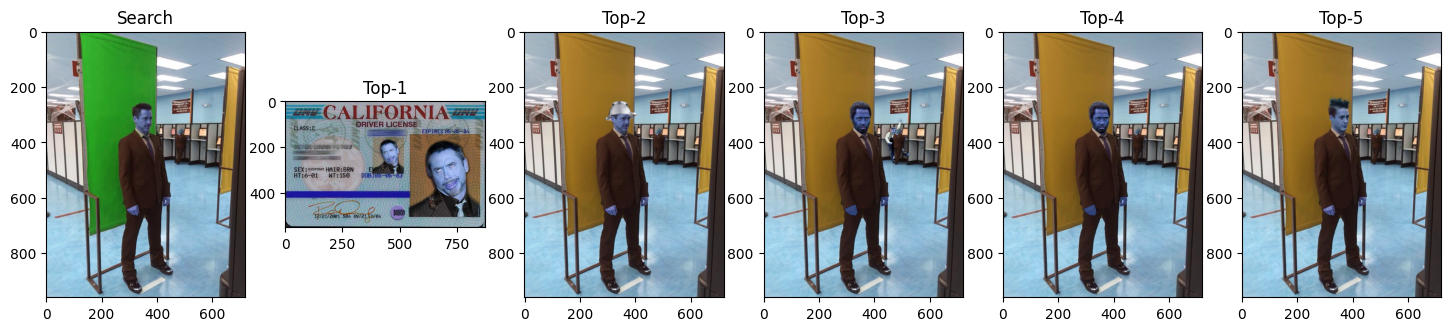

In [14]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# Display top images
vote_list = list(reversed(sorted([(path, count) for path, count in vote.items()], key=lambda x: x[1])))
img_list = [path for path, _ in vote_list]

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[18,10])
ax[0].imshow(cv2.imread("reddit-images/g1190_clna260.jpg"))
ax[0].set_title("Search")

for i in range(5):
    axi = ax[i + 1]
    img = cv2.imread(img_list[i])
    axi.imshow(img)
    axi.set_title(f"Top-{i + 1}")

plt.show()